In [1]:
include("./combinedsmcs.jl")

┌ Info: Recompiling stale cache file /Users/abird/.julia/compiled/v1.0/PyPlot/oatAj.ji for PyPlot [d330b81b-6aea-500a-939a-2ce795aea3ee]
└ @ Base loading.jl:1184
┌ Info: Recompiling stale cache file /Users/abird/.julia/compiled/v1.0/Formatting/vCa4N.ji for Formatting [59287772-0a20-5a39-b81b-1366585eb4c0]
└ @ Base loading.jl:1184
┌ Info: Recompiling stale cache file /Users/abird/.julia/compiled/v1.0/Clustering/Ovl2Q.ji for Clustering [aaaa29a8-35af-508c-8bc3-b662a17a0fe5]
└ @ Base loading.jl:1184
┌ Info: Recompiling stale cache file /Users/abird/.julia/compiled/v1.0/Parameters/ycYNs.ji for Parameters [d96e819e-fc66-5662-9728-84c9c7592b0a]
└ @ Base loading.jl:1184


combined_smcs (generic function with 1 method)

In [2]:
using PyPlot
using Distributions
using LinearAlgebra
using Formatting
using Flux
using Flux: Tracker
using StatsBase
using Clustering
using Parameters
using Random
using Flux.Tracker: TrackedReal, track, @grad
using Flux: testmode!

## Banana Distribution

In [3]:
function p_log_banana(X)
    b = 100
    s = 0.03
    div1 = 10.
    x1 = X[:,1]./div1
    return -x1.^2/(2*s) - 0.5*(X[:,2] - b.*(x1.^2 .- s)).^2
end

function p_log_banana_beta(x, beta)
    f_x = p_log_banana(x)
    return (1-beta)*p_log_prop(x) + beta*f_x, f_x
end

const prop_var = 10^2
# implicitly proposal mean is 0

function p_log_prop(X)
    @assert ndims(X) == 2
    n, d = size(X)
    @assert d != 1
    Z = X .* (1/sqrt(prop_var))
    exponent = -0.5*sum(Z.^2, dims=2)
    lognormconst = -(d/2)*log(2*pi*prop_var)
    return exponent .+ lognormconst
end


p_log_prop (generic function with 1 method)

In [4]:
csmcs_opt()

csmcs_opt
  prior_std: Float64 10.0
  gris_rsmp_every: Int64 1
  gris_sqrtdelta: Float64 1.0
  ais_betas: Array{Float64}((1,)) [1.0]
  diagnostics: Bool false
  gris_grad_delta: Float64 1.0
  gris_burnin: Int64 0
  gris_epochs: Int64 60
  gris_nsmp: Int64 50
  amis_kcls: Int64 6
  amis_epochs: Int64 30
  gmm_smp: Int64 5000
  gmm_tilt: Float64 2.0


In [5]:
S, W = combined_smcs(p_log_banana_beta, p_log_banana, csmcs_opt(ais_betas=range(0.01, stop=1., length=30), 
        gris_burnin=30, gris_grad_delta=1e-5))

([-0.093511 -2.79811; -0.228401 -0.60296; … ; -2.6398 4.9523; -3.38177 8.89095], [9.22029, 4.93845, 12.2183, 6.94741, 11.4075, 11.2583, 7.67553, 11.6713, 11.2097, 8.87733  …  4.34506, 5.70243, 7.20616, 11.0465, 8.81969, 7.98977, 11.0073, 8.5932, 33.2663, 8.33533], Array{Float64,N} where N[[0.371449, 0.227852, 0.0, 0.0949147, 0.238232, 0.0675525], [-0.0510444 -2.64512; -1.54787 -0.200353; … ; 1.45473 -0.522166; -3.3473 8.51702], [0.312746 -0.0729887; -0.0729887 0.981193]

[0.351349 -1.11867; -1.11867 4.37508]

[0.00896669 -0.0114508; -0.0114508 0.108462]

[0.402648 2.52914; 2.52914 16.7445]

[0.415293 1.24692; 1.24692 4.64486]

[0.390323 -2.73713; -2.73713 20.3177]])

## MNIST => Nonlinear Factor Analysis

In [21]:
using Flux, Flux.Data.MNIST
using Flux: throttle, params
using Juno: @progress

In [218]:
llh_weight_matrix_bern([0 1 1 0; 1 0 0 0; 0 1 0 0], [0.2 0.9 0.9 0.1; 0.9 0.9 0.5 0.1; 0.5 0.5 0.5 0.5; 0.1 .9 .9 .9])

(4, 1)
(4, 4)
(3, 4)


3×4 Array{Float64,2}:
 -0.539225  -3.20645  -2.77259  -2.61867
 -6.31997   -3.20645  -2.77259  -9.21034
 -2.73645   -3.20645  -2.77259  -4.81589

In [219]:
sum([logpdf(Bernoulli(p), x) for (p,x) in zip([0.9 0.9 0.5 0.1],  [1 0 0 0])])

-3.206453304869644

In [132]:
function llh_weight_matrix_bern(X, P)
    """
    constructs log likelihood matrix of all combinations
    of all rows of X and P=f(Z) according to log bernoulli
    """
    logf = log.(P)
    log1mf = log.(1. .- P)

    # bounding range stops us exploding to infinity
    # (ending up with NaNs -- 0 * np.inf etc. This should
    # be rare and if p(X=x) = exp(-1e16), X \ne x in practice.)
    logf = max.(logf, -1e16)
    log1mf = max.(log1mf, -1e16)
    
    log1mf_norm_sum = sum(log1mf, dims=2)
    logs_diff = logf - log1mf

    out = X * logs_diff' .+ log1mf_norm_sum'
    return out
end

function snis_weight_matrix_bern(X, P; logtilt=0)
    w = llh_weight_matrix_bern(X, P)
    w = logtilt==0 ? w : w .+ logtilt'
    W = softmax2(w, dims=2)
    return W
end

function obswise_posterior_samples_bern_viz(X, Tfn, rank, n_proposal)
    Zproposal = randn(n_proposal, rank)
    Xhat = Tfn(Zproposal')
    f, ax = PyPlot.subplots(1,1, figsize=(10,6))
    ax[:imshow](snis_weight_matrix_bern(X, Xhat'))
end


function obswise_posterior_samples_bernllh(X, Tfn, rank, n_proposal, n_est; sigma2=1.)
    # Returns an array of samples of Z where 0:n_est are for i=0,
    # (n_est+1):(2*n_est) are for i=1, ... etc. Due to speed of torch variable getattr.
    Zproposal = randn(n_proposal, rank)*sqrt(sigma2)
    Xhat = Tfn(Zproposal')
    # Exponential tilting for sampling w overdispersed prior
    tilt = 0
    if abs(sigma2 -1) > 1e-7
        normZ = sum(Zproposal.^2, dims=2)
        tilt = (1-sigma2)/(2*sigma2) * normZ   # log tilt
    end
    
    W = snis_weight_matrix_bern(X', Xhat', logtilt=tilt)
#     PyPlot.plt[:imshow](copy(softmax2(llh_weight_matrix_bern(a', decoder(Zproposal').data'), dims=2)[1:100,:]), aspect="auto")
#     PyPlot.plt[:imshow](copy(W), aspect="auto")
    
    smps = [multinomial_indices(n_est, W[i,:]/sum(W[i,:])) for i ∈ 1:size(X,2)]
    smps = reduce(vcat, smps)
    
    return Zproposal[smps, :]
end

obswise_posterior_samples_bernllh (generic function with 1 method)

In [8]:
using Flux, Flux.Data.MNIST
using Flux: throttle, params

# Load data, binarise it, and partition into mini-batches of M.
X = float.(hcat(vec.(MNIST.images())...)) .> 0.5
N, M = size(X, 2), 100
data = [X[:,i] for i in Iterators.partition(1:N,M)];

Xtest = float.(hcat(vec.(MNIST.images(:test))...)) .> 0.5
Ntest = size(Xtest, 2)
data_test = [Xtest[:,i] for i in Iterators.partition(1:Ntest,M)];

In [9]:
@with_kw struct nlfa_opts
    nepochs::Int64 = 30
    adam_eta::Float64 = 1e-3
    L::Int64 = 1
    n_proposal::Int64 = 200
    info_interval::Int64 = 10
    sigma2::Float64 = 1.
    d_z::Int64 = 2
    d_h::Int64 = 500
    d_obs::Int64 = 28^2
end

nlfa_opts

In [263]:
obswise_posterior_samples_bernllh(a

54401.282418444185 (tracked)

In [38]:
function gen_cube_grid(vmin, vmax; nsmp_dim=8, ndim=2, force=false)
        """
    Generate coordinates for equally spaced meshgrid in `ndim` dimensions.
    The output is in 'long' rather than 'wide' form: i.e. if `ndim=2`,
    an n x 2 matrix is returned.
    :param vmin: minimum value for each axis
    :param vmax: maximum value for each axis
    :param nsmp_pdim: number of samples per dimension
    :param ndim: number of dimensions
    :param force: function raises an error if the returned matrix is longer
    than 1e4 rows. If one wants more than 1e4 rows, set `force=True`.
    :return: (nsmp_pdim**ndim, ndim) array.
    """
    if (!force) && nsmp_dim^ndim > 1e4
        throw("More than 10,000 points requested.")
    end

    xs = collect(range(vmin, stop=vmax, length=nsmp_dim))
    xs = hcat(repeat(xs, outer=(nsmp_dim,1)), repeat(xs, inner=(nsmp_dim,1)))
    return xs
end

gen_cube_grid (generic function with 1 method)

In [41]:
gen_cube_grid(-2, 2, nsmp_dim=4)

16×2 Array{Float64,2}:
 -2.0       -2.0     
 -0.666667  -2.0     
  0.666667  -2.0     
  2.0       -2.0     
 -2.0       -0.666667
 -0.666667  -0.666667
  0.666667  -0.666667
  2.0       -0.666667
 -2.0        0.666667
 -0.666667   0.666667
  0.666667   0.666667
  2.0        0.666667
 -2.0        2.0     
 -0.666667   2.0     
  0.666667   2.0     
  2.0        2.0     

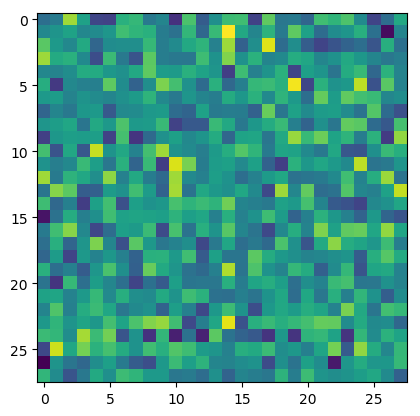

PyObject <matplotlib.image.AxesImage object at 0xa31c8a630>

In [70]:
PyPlot.plt[:imshow](copy(reshape(decoder([1; 0]), 28, 28).data))

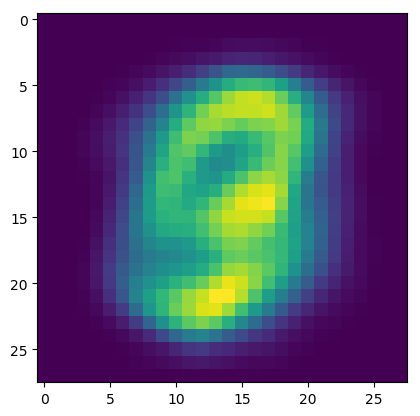

PyObject <matplotlib.image.AxesImage object at 0xa303f8940>

In [67]:
PyPlot.plt[:imshow](copy(reshape(decoder([0; 1]), 28, 28).data))

In [141]:
zs = gen_cube_grid(-2, 2, nsmp_dim=8)
out = zeros(28*8, 28*8)
for ii in 1:size(zs, 1)  
    img = copy(reshape(decoder(zs[ii,:]).data, (28, 28)))
    ix_xs = ((ii-1) % 8)*28 + 1 : ((ii-1) % 8)*28 + 28
    ix_ys = ((ii-1) ÷ 8)*28 + 1 : ((ii-1) ÷ 8)*28 + 28
#     println([ix_xs, ix_ys])
    out[ix_xs, ix_ys] = img
end

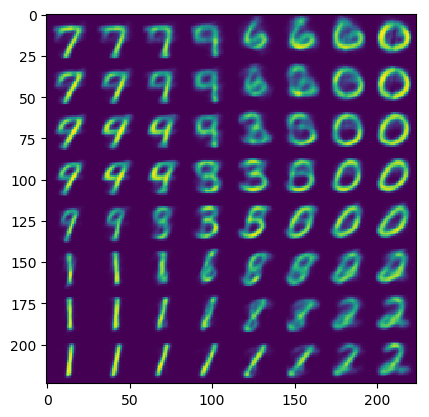

PyObject <matplotlib.image.AxesImage object at 0xa30d70400>

In [142]:
ax = PyPlot.plt[:imshow](out)
# savefig("THISISML.pdf")

In [83]:
size(decoder(Zproposal').data')

(100, 784)

In [84]:
size(llh_weight_matrix_bern(a', decoder(Zproposal').data'))

(100, 100)

In [118]:
decoder = Chain(Dense(d_z, d_h, tanh), Dense(d_h, d_obs, σ))
optim = ADAM(params(decoder), opts.adam_eta)

#43 (generic function with 1 method)

In [18]:
loss(a)

54081.96475386747 (tracked)

In [139]:
opts = nlfa_opts(sigma2=2, n_proposal=500)
@assert isa(opts, nlfa_opts)
@unpack nepochs, info_interval, d_z, d_h, d_obs = opts

function loss(x)
    testmode!(decoder)
    Z_post_all = obswise_posterior_samples_bernllh(x,  
                x -> decoder(x).data, d_z, opts.n_proposal, opts.L, sigma2=opts.sigma2)
    testmode!(decoder, false)
    P = decoder(Z_post_all')
    Xrepelem = repeat(x, inner=(1, opts.L))
    return sum(Flux.binarycrossentropy.(P, Xrepelem))
end
    
# evalcb = throttle(() -> @show(loss(a), 30))
# @progress for i = 1:1
#   println("Epoch $i")
#   Flux.train!(loss, zip(data), optim, cb=evalcb)
# end
@progress for i = 1:4
  println("Epoch $i")
  Flux.train!(loss, zip(data), optim)
end

Epoch 1
Epoch 2
Epoch 3
Epoch 4


In [ ]:
function nlfa_is(k, opts):
    @assert isa(opts, nlfa_opts)
    @unpack nepochs, info_interval, d_z, d_h, d_obs = opts

    # Generative model / "decoder" MLP.
    decoder = Chain(Dense(d_z, d_h, tanh), Dense(d_h, d_obs, σ))
    
    opt = ADAM(params(A, μ, logσ, f), η=opts.adam_eta)
    
    
    # ====== OPTIMISATION ==================
    def run_model(epoch, test=False):
        train_loss = 0
        data_loader = train_loader if not test else test_loader
        N = len(data_loader.dataset)
        print('IS proposals: {:d}'.format(n_proposal))
        for batch_idx, (data, _) in enumerate(data_loader):
            if (not test) and batch_idx > 7:
                break
            X = Variable(data, requires_grad=False)
            
            Z_post_all = obswise_posterior_samples_bernllh(X.clone().data.view(-1,784).numpy(),  
                                          Tfn_np, k, n_proposal, opts['L'], sigma2=opts['sigma2'])
            
            P = decoder(Z_post_all)
            Xrepelem = repeat(X, inner=(opts['L'], 1))
            logp = F.binary_cross_entropy(P, Xrepelem.view(-1,784), size_average=False)
            train_loss += logp.data[0]
            
            if not test:
                logp.backward()
                optimizer.step()
            
                if batch_idx % log_interval == 0:
                    history[hh] = logp.data[0] / (len(data)*opts['L'])
                    hh +=1
                    print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                        epoch, batch_idx * len(data), len(data_loader.dataset),
                        100. * batch_idx / len(data_loader),
                        logp.data[0] / (opts['L']*len(data))))
            else:
                if batch_idx + 1 == len(data_loader):
                    history = np.array([train_loss / (N * opts['L'])])

        print('====> Epoch: {} {:s} Average loss: {:.4f}'.format(
              epoch, ['Train', 'Test'][test==True], train_loss / (N * opts['L'])))
        
        return history
    
    
    def train(epoch):
        return run_model(epoch, test=False)
    def test(epoch):
        return run_model(epoch, test=True)
    
    full_hist = np.zeros(0)
    full_hist_test = np.zeros(0)
    full_times = np.zeros((0,6))
    for epoch in range(1, nepochs + 1):
        history, times = train(epoch)
        history_test, _t = test(epoch)
        # reporting
        full_times = np.concatenate((full_times, times), 0)
        full_hist = np.concatenate((full_hist, history), 0)
        full_hist_test = np.concatenate((full_hist_test, history_test), 0)
        # create image
        grsz = 8
        sample = axu.manipulate.gen_cube_grid(-2,2,grsz,ndim=2)
        sample = Variable(torch.from_numpy(sample).float(), requires_grad=False)
        sample = vae_AD.decode(sample).cpu()
        save_image(sample.data.view(grsz**2, 1, 28, 28),
                   'tmp-results/sample_' + str(epoch) + '.png', nrow=grsz)
    
            
    return vae_AD, (full_hist, full_hist_test), full_times